# Project: Problem Statement - Credit Card Customer Segmentation
## AllLife Credit Card Customer Segmentation

 

 

### Background: 
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the bank poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

 

### Objective: 
To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

 

### Key Questions:

* How many different segments of customers are there?
* How are these segments different from each other?
* What are your recommendations to the bank on how to better market to and service these customers?
 

### Data Description: 
Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call.

* Customer key - Identifier for the customer
* Average Credit Limit - Average credit limit across all the credit cards
* Total credit cards - Total number of credit cards
* Total visits bank - Total number of bank visits
* Total visits online - total number of online visits
* Total calls made - Total number of calls made by the customer

___

### EDA

Importing libraries to perform EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.float_format = '{:,.2f}'.format

Creating the dataframe and viewing the first 5 rows

In [2]:
df = pd.read_excel('Credit Card Customer Data.xlsx')
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


'Sl_No' and 'Customer Key' is not needed, so I will drop these columns and verify the drop by looking at the top 5 rows again

In [3]:
df.drop(['Sl_No', 'Customer Key'], axis=1, inplace=True)
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


Next, I will describe the data to get an initial idea of what we are working with

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.00,"34,574.24","37,625.49","3,000.00","10,000.00","18,000.00","48,000.00","200,000.00"
Total_Credit_Cards,660.00,4.71,2.17,1.00,3.00,5.00,6.00,10.00
Total_visits_bank,660.00,2.40,1.63,0.00,1.00,2.00,4.00,5.00
Total_visits_online,660.00,2.61,2.94,0.00,1.00,2.00,4.00,15.00
Total_calls_made,660.00,3.58,2.87,0.00,1.00,3.00,5.00,10.00


Based on these descriptive statistics, 'Avg_Credit_Limit' may have a right skewness.  Let's visualize these features using histograms

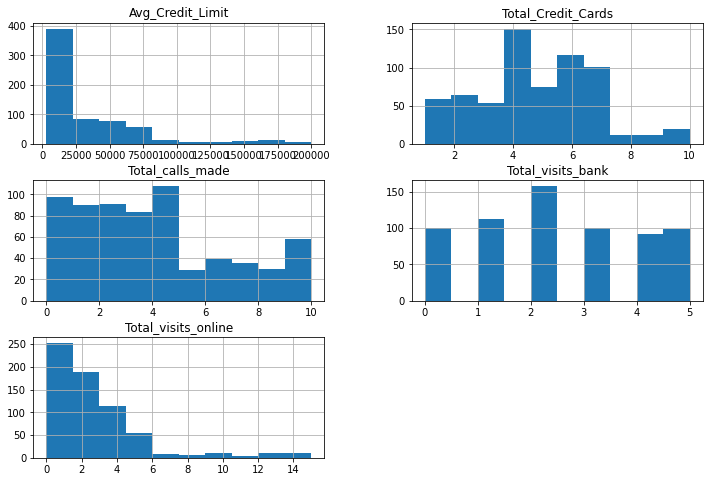

In [5]:
df.hist(figsize=(12,8))
plt.show()

* 'Avg_Credit_Limit' does seem to have a heavy skewness to the right, with many limits being below 25,000
* 'Total_visits_online' also seems to have a slight right skewness

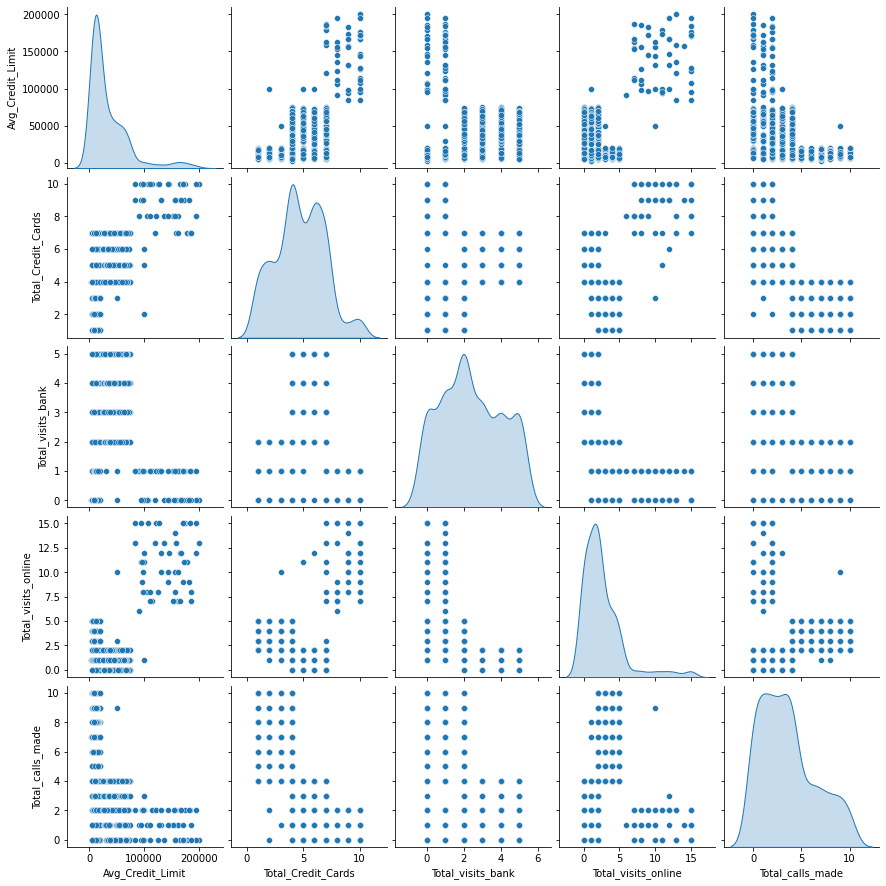

In [6]:
sns.pairplot(df, diag_kind='kde')
plt.show()

* The 'Total_Credit_Card' feature looks like it may have 2 to 4 clusters
* Customers with higher credit limits tend to make fewer calls and fewer bank visits, but more online visits.  They also tend to have more credit cards.
* Customers with lower credit limits inversely make more calls and in person visits, with fewer online visits and a fewer number of credit cards.

__Initial Takeaways:__
* Customers with higher limits use the online services more.  Perhaps marketing to them online or through the website will be best.  Direct mail or call marketing may be better for those with lower credit limits, or perhaps in person promotions when visiting branch locations.

#### Bivariate Analysis

I want to look at interactions made with the bank as well as spending habits.  
* Interaction related features: 'Total_calls_made', 'Total_visits_online', and 'Total_visits_bank' 
* Spending related features: 'Total_Credit_Cards', 'Avg_Credit_Limit'

Let's look at the relationship between credit cards and credit limits

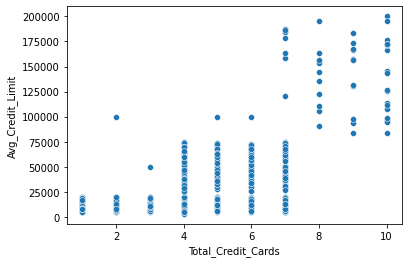

In [7]:
sns.scatterplot(x='Total_Credit_Cards', y='Avg_Credit_Limit', data=df)
plt.show()

* as expected, there seems to be some form of linear relationship between number of credit cards and credit limit

In [8]:
df.nunique()

Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

Let's see how each interaction type fits into this analysis

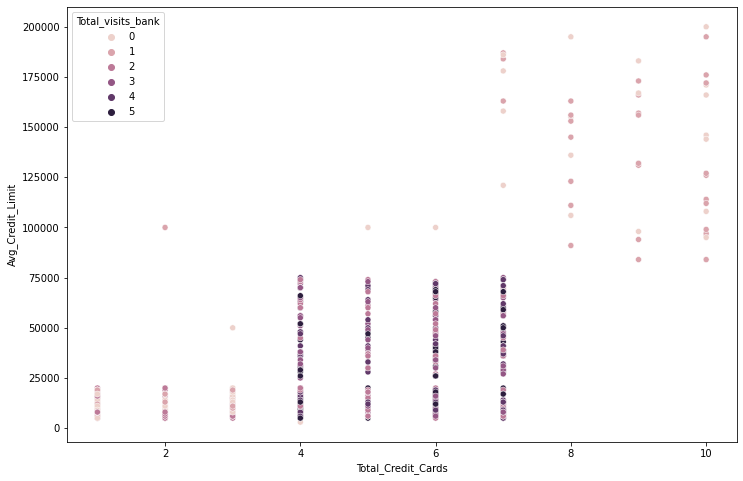

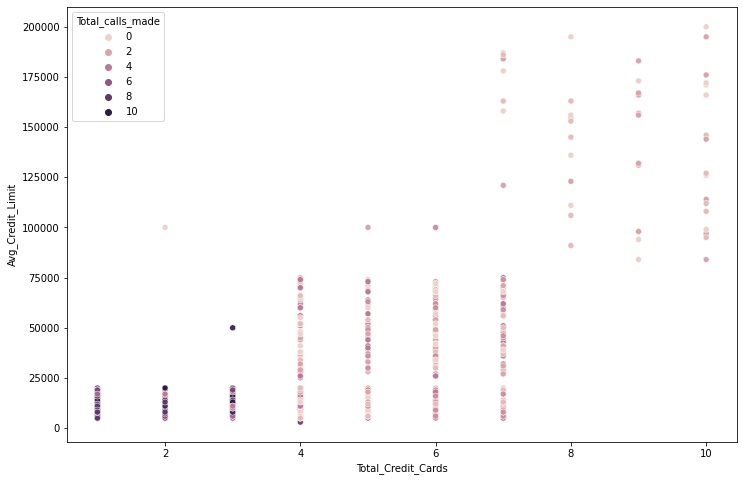

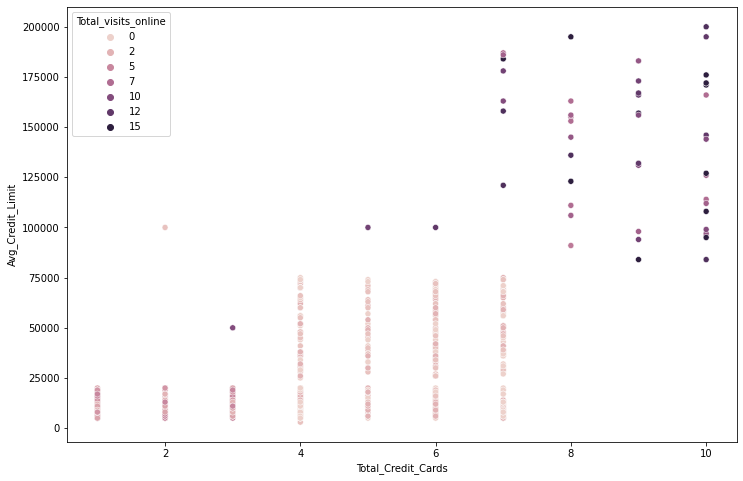

In [9]:
hues = ['Total_visits_bank', 'Total_calls_made', 'Total_visits_online']

for h in hues:
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Total_Credit_Cards', y='Avg_Credit_Limit', hue=h, data=df)
    plt.show()

__Bank Visits:__ It appears that the majority of bank visits occur in customers with 4 to 7 credit cards and under $75,000 credit limit.
* this could signify that there is a cluster in the middle of our distribution between the lower limit/lower card # customers and the higher limit/higher card # customers (online focused)

__Calls:__ It looks as though the lower credit limit/lower # card customers make the most calls to the bank.  All calls greater than 6 look to be coming from customers with 3 or fewer credit cards and a credit limit of under $25,000 outside of a couple outliers
* This further suggest 3 potentially useful clusters in 3 spending categories. Each cluster may be more receptive to different marketing channels (in person, phone call, and online)

__Online Visits:__ As suspected, those users with the highest credit limits and most credit cards account for most online visits (10+ per customer)
* This gives me strong confidence in the 3 potential clusters

### Clustering
I will now build out my clustering models starting with KMeans, then moving on to Hierarchical

#### KMeans

First, I will import the proper libraries and scale my data using zscore

In [10]:
from sklearn.cluster import KMeans
from scipy.stats import zscore

In [11]:
Z = df.apply(zscore)
Z.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.74,-1.25,-0.86,-0.55,-1.25
1,0.41,-0.79,-1.47,2.52,1.89
2,0.41,1.06,-0.86,0.13,0.15
3,-0.12,0.14,-0.86,-0.55,0.15
4,1.74,0.60,-1.47,3.20,-0.20


Now we will create an elbow plot for a range of cluster numbers

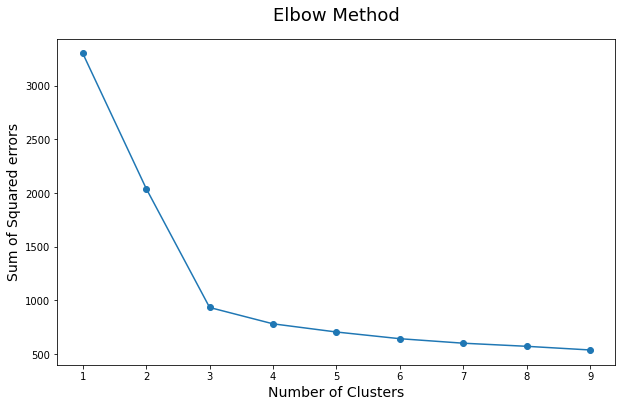

In [12]:
clusters = range(1,10)
errors = []

for k in clusters:
    model = KMeans(k)
    model.fit(Z)
    centroids = model.cluster_centers_
    errors.append(model.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(clusters, errors, marker='o')
plt.ylabel('Sum of Squared errors', {'fontsize':14})
plt.xlabel('Number of Clusters', {'fontsize':14})
plt.title('Elbow Method', {'fontsize':18}, pad=18)
plt.show()

* 3 clusters is the ideal number based on the elbow method plot.  This aligns well with our EDA from earlier.

#### KMeans

Next, I will run the KMeans model on the desired number of clusters (3 in this case) and will sum the counts of data points per label

In [13]:
num = 3
kmeans = KMeans(3, n_init=5, random_state=14)
kmeans.fit(Z)

KMeans(n_clusters=3, n_init=5, random_state=14)

In [14]:
labels = kmeans.labels_
counts = np.bincount(labels)
counts

array([ 50, 386, 224])

Now I will look at the centers of each cluster

In [15]:
kmeans_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns = Z.columns).T
kmeans_centers_df

,0,1,2
Avg_Credit_Limit,2.83,-0.02,-0.60
Total_Credit_Cards,1.86,0.37,-1.06
Total_visits_bank,-1.11,0.67,-0.90
Total_visits_online,2.83,-0.55,0.32
Total_calls_made,-0.87,-0.55,1.15


Initial Observations:
* Cluster 0 has a higher average credit limit and number of credit cards than the other 2 clusters, as well as a higher online visit number.  This aligns with our initial EDA observations.
* Bank visits has a higher value for cluster 1.  Earlier, we found that there was likely a cluster in the mid range like this one we see here.
* Cluster 2 has the highest phonecall number and the lowest average credit card limit and number of cards.  This aligns again to our EDA analysis before of the lower spenders accounting for more phone calls.

Now let's add the labels to the dataframe

In [16]:
df_kmeans = df.copy()
df_kmeans['labels'] = labels
df_kmeans.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,100000,2,1,1,0,1
1,50000,3,0,10,9,2
2,50000,7,1,3,4,1
3,30000,5,1,1,4,1
4,100000,6,0,12,3,0


I will also view the feature averages by cluster and for the whole dataframe

In [17]:
df_kmeans.groupby('labels').mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,"141,040.00",8.74,0.60,10.90,1.08
1,"33,782.38",5.52,3.49,0.98,2.00
2,"12,174.11",2.41,0.93,3.55,6.87


In [18]:
df_kmeans.describe().loc[['mean']]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
mean,"34,574.24",4.71,2.40,2.61,3.58,1.26


Now that we have added the group labels to the dataset, we can view the data via boxplots

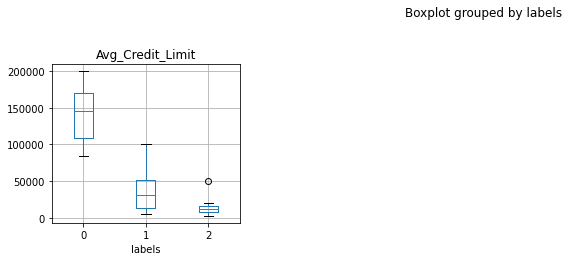

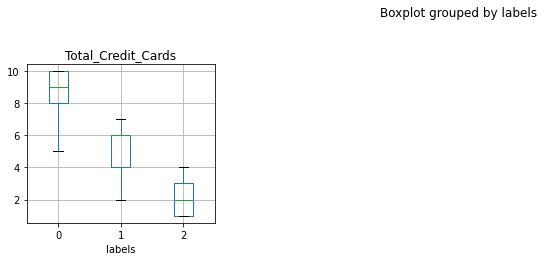

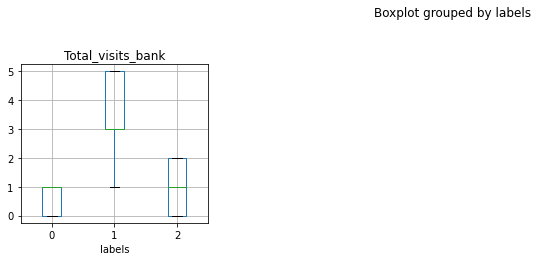

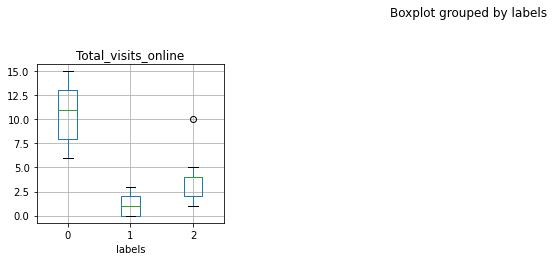

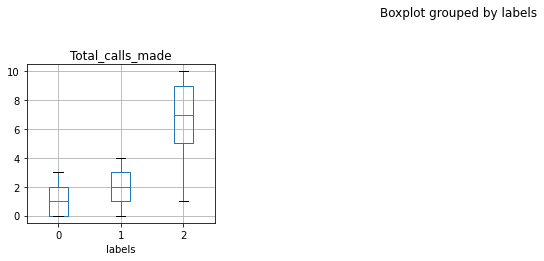

In [19]:
for c in df_kmeans.columns:
    if c != 'labels':
        df_kmeans.boxplot(column=c, by='labels',layout=(3,4), figsize=(15, 10))

__KMeans Observations:__

My initial observations line up well with what we are seeing in these boxplots.
* Class 0: High number of credit cards and high credit limit paired with the most online interactions.  Very low calls and visits to the bank made.
* Class 1: Average number of credit cards and credit limit.  These customers visit the bank most frequently, but make relatively few online visits and phone calls.
* Class 2: These customers make the most phone calls.  They also have the fewest number of credit cards and the lowest credit limit.

#### Hierarchical

In [20]:
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist  #Pairwise distribution between data points

In [21]:
Z

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.74,-1.25,-0.86,-0.55,-1.25
1,0.41,-0.79,-1.47,2.52,1.89
2,0.41,1.06,-0.86,0.13,0.15
3,-0.12,0.14,-0.86,-0.55,0.15
4,1.74,0.60,-1.47,3.20,-0.20
...,...,...,...,...,...
655,1.71,2.44,-0.86,2.52,-1.25
656,1.31,2.44,-0.86,3.54,-0.55
657,2.94,1.52,-0.86,2.18,-0.90
658,3.66,2.44,-0.86,4.22,-1.25


In [22]:
alg = Z.copy()

In [23]:
alg.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.74,-1.25,-0.86,-0.55,-1.25
1,0.41,-0.79,-1.47,2.52,1.89
2,0.41,1.06,-0.86,0.13,0.15
3,-0.12,0.14,-0.86,-0.55,0.15
4,1.74,0.60,-1.47,3.20,-0.20


I will use a for loop to identify the best linkage method

In [24]:
methods = ["ward", "complete", "average", "single", "centroid"]
for m in methods:
    link = linkage(alg, method=m, metric='euclidean') #create linkage of scaled data
    c, coph_matrix = cophenet(link, pdist(alg)) # calculate cophenetic distance of linkage
    print(m, ':', round(c, 3)) # print out the cophenetic index score

ward : 0.742
complete : 0.86
average : 0.898
single : 0.739
centroid : 0.894


The *average* method looks to be the best performer followed by *centroid*.  I will create an agglomerative clustering model using these two linkage methods.

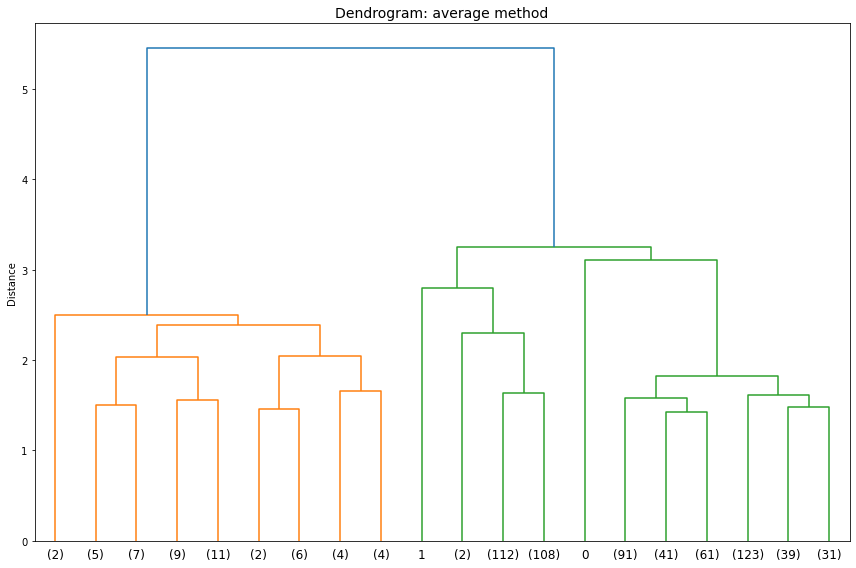

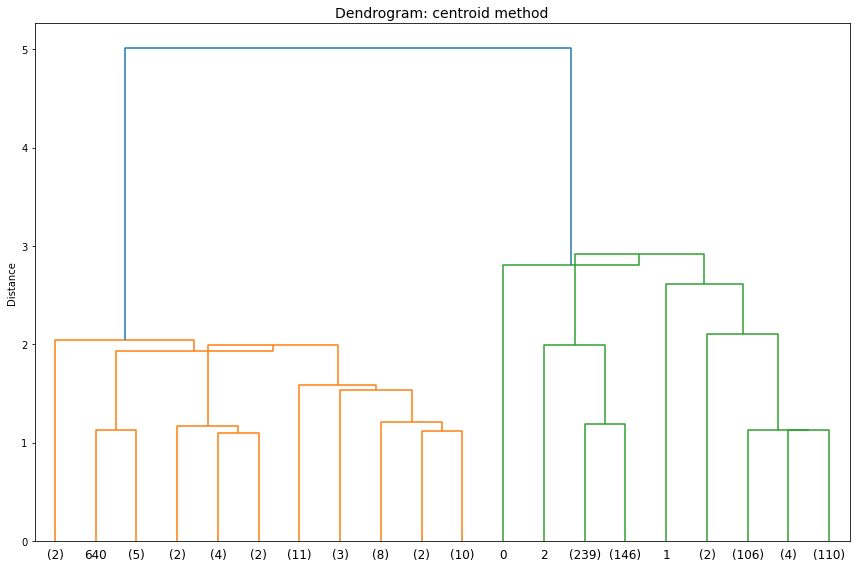

In [25]:
lnk_mth = ['average', 'centroid']
for lm in lnk_mth:
    scaled = linkage(alg, method=lm, metric='euclidean') #create linkage of scaled data
    plt.figure(figsize=(12,8))
    plt.title('Dendrogram: {} method'.format(lm), fontdict={'fontsize': 14})
    plt.ylabel('Distance')
    dendrogram(scaled, truncate_mode='lastp', p=20)
    plt.tight_layout()

Next, Let's view the dendrogram for our 3 clusters

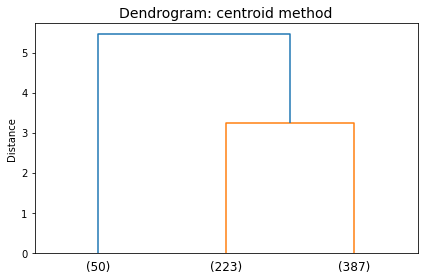

In [26]:
Z_dend = linkage(alg, method='average', metric='euclidean') #create linkage of scaled data
plt.title('Dendrogram: {} method'.format(lm), fontdict={'fontsize': 14})
plt.ylabel('Distance')
dendrogram(Z_dend, truncate_mode='lastp', p=3)
plt.tight_layout()

Now I will build out the agglomerative clustering using the *average* linkage method for 3 clusters

In [27]:
df_alg3 = df.copy()

alg_model = AgglomerativeClustering(n_clusters=3, linkage='average')
alg_model.fit(alg)
df_alg3['labels'] = alg_model.labels_
df_alg3.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,100000,2,1,1,0,0
1,50000,3,0,10,9,2
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,1


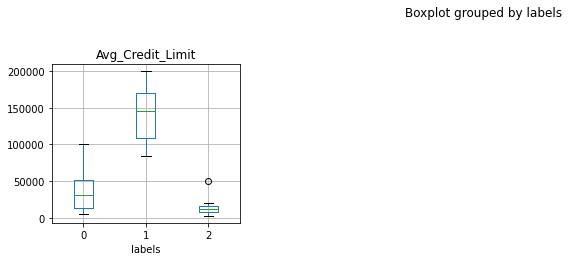

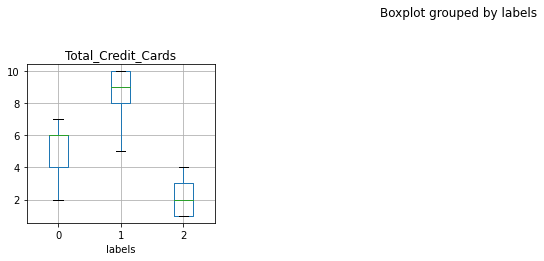

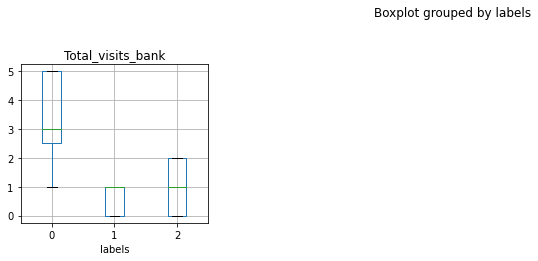

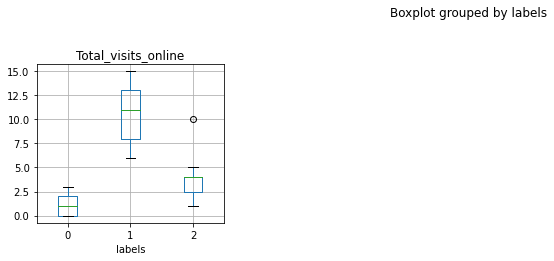

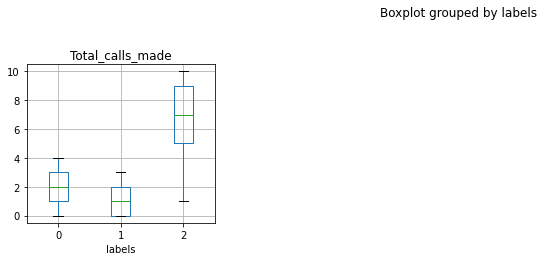

In [28]:
for c in df_alg3.columns:
    if c != 'labels':
        df_alg3.boxplot(column=c, by='labels',layout=(3,4), figsize=(15, 10))

* Looking at the boxplots, we see very similar results to KMeans clustering.  The only difference is the label numbers. 

In [29]:
from sklearn.metrics import silhouette_score
print("KMeans Silhouette Score: ", round(silhouette_score(Z, labels), 3))
print("Hierarchical Silhouette Score: ", round(silhouette_score(alg, alg_model.labels_), 3))

KMeans Silhouette Score:  0.516
Hierarchical Silhouette Score:  0.516


* By the looks of it, KMeans performs best

### Key Questions:

* How many different segments of customers are there?
* How are these segments different from each other?
* What are your recommendations to the bank on how to better market to and service these customers?

1. There are 3 customer segments
2. These segmenets differ in the following ways
    * Some customers have a large number of credit cards and a high credit rating.  These customers primarily interact with the bank online.
    * Other customer have few credit cards and a low credit limit.  These customers tend to call the bank.
    * the last segment of customer is inline with the average credit card limit and number of cards.  These customers visit the physical bank the most.
3. I would recommend that the bank market to these 3 segments in 3 different ways.
    * The high credit users should be targeted with an online campaign
    * The low credit users should be targeted in person when visiting the bank
    * The average credit users should be targeted through direct calls